In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MADRONA_MWGPU_KERNEL_CACHE"]="/scratch/ankit/madrona_mjx/build/kernel_cache"
os.environ["MADRONA_BVH_KERNEL_CACHE"]="/scratch/ankit/madrona_mjx/build/bvh_cache"
os.environ["MUJOCO_GL"]="egl"
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [2]:
from myosuite.train.myouser.custom_ppo.networks_vision_multimodal import make_cnn_encoder, make_cnn_decoder
from myosuite.train.utils.wrapper import wrap_curriculum_training
import flax
from brax.training.networks import FeedForwardNetwork
from ArmReach_LLC_UitB import main
from typing import Mapping, Tuple
import jax
import jax.numpy as jnp
from brax.training.types import Params
import matplotlib.pyplot as plt

MyoSuite:> Registering Myo Envs
MyoSuite:> Registering MyoUser Envs


In [3]:
@flax.struct.dataclass
class AutoEncoder:
    encoder: FeedForwardNetwork
    decoder: FeedForwardNetwork

In [16]:


@flax.struct.dataclass
class AutoEncoder:
    encoder: FeedForwardNetwork
    decoder: FeedForwardNetwork

def make_autoencoder(observation_size: Mapping[str, Tuple[int, ...]], latent_size: int):
    encoder = make_cnn_encoder(observation_size=observation_size, vision_output_size=latent_size)
    decoder = make_cnn_decoder(observation_size=(latent_size,))


    # dummy_obs = {
    #   key: jnp.zeros((1,) + shape) for key, shape in observation_size.items()}
    
    # dummy_latent = jnp.zeros((1, latent_size))

    def init(key):
        encoder_key, decoder_key = jax.random.split(key)
        encoder_params = encoder.init(encoder_key)
        decoder_params = decoder.init(decoder_key)
        return (encoder_params, decoder_params)
    
    def apply(params, obs):
        encoder_params, decoder_params = params
        encoded = encoder.apply(encoder_params, obs)
        decoded = decoder.apply(decoder_params, encoded)
        return decoded
    
    return FeedForwardNetwork(init=init, apply=apply)
    


In [29]:
observation_size = {
    'pixels/depth': (120, 120, 1),
}

NUM_ENVS = 128

autoencoder = make_autoencoder(observation_size=observation_size, latent_size=40)

autoencoder_params = autoencoder.init(jax.random.PRNGKey(0))

In [6]:
env = main(experiment_id='autoencoder_default', project_id='test_autoencoder', adaptive_increase_success_rate=1.1,
           adaptive_decrease_success_rate=-0.1, init_target_area_width_scale=1.0, get_env_only=True, num_envs=NUM_ENVS, vision_mode='depth')

/scratch/ankit/miniforge3/envs/madmjx/lib/python3.11/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


Overriding reach weight to 1.0
Overriding bonus weight to 8.0
Overriding reach metric coefficient to 10.0
Reach metric coefficient: 10.0
Reward keys and weights: {'reach': 1.0, 'bonus': 8.0, 'neural_effort': 0}
Using vision, so 2.5x timesing dwell threshold to 12.5
Using raytracer
loading BVH kernels from cache
Initialization finished


In [7]:
jit_reset = jax.jit(env.reset)
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), NUM_ENVS))

In [8]:
images = state.obs['pixels/depth']

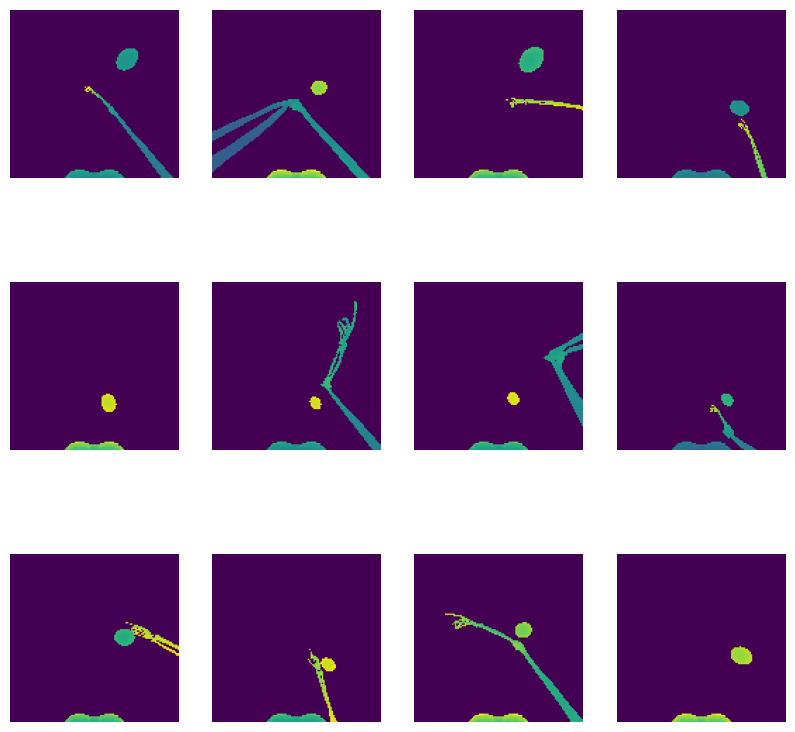

In [9]:
fig, ax = plt.subplots(3, 4, figsize=(10, 10))

for i in range(3):
    for j in range(4):
        ax[i, j].imshow(state.obs['pixels/depth'][i*4 + j])
        ax[i, j].axis('off')

plt.show()

In [30]:
vision_obs = {
    'pixels/depth': state.obs['pixels/depth'],
}

autoencoder_output = autoencoder.apply(autoencoder_params, vision_obs)

In [31]:
def mse_loss(pred, target):
    diff = pred - target
    return jnp.mean(diff * diff)

In [32]:
mse_loss(autoencoder_output, state.obs['pixels/depth'])

Array(0.00416818, dtype=float32)

  0%|          | 2/1000 [00:07<53:18,  3.20s/it]  

Step 0, Loss: 0.004020541440695524


 14%|█▎        | 137/1000 [00:08<00:13, 62.82it/s]

Step 100, Loss: 0.0009818179532885551


 24%|██▍       | 245/1000 [00:08<00:04, 158.47it/s]

Step 200, Loss: 0.0008915784419514239


 35%|███▌      | 353/1000 [00:09<00:02, 229.16it/s]

Step 300, Loss: 0.000742452044505626


 43%|████▎     | 434/1000 [00:09<00:02, 252.21it/s]

Step 400, Loss: 0.0008082214626483619


 54%|█████▍    | 542/1000 [00:09<00:01, 261.88it/s]

Step 500, Loss: 0.0007338054710999131


 65%|██████▌   | 650/1000 [00:10<00:01, 264.32it/s]

Step 600, Loss: 0.0007033218280412257


 73%|███████▎  | 731/1000 [00:10<00:01, 265.40it/s]

Step 700, Loss: 0.0006540960748679936


 84%|████████▍ | 839/1000 [00:10<00:00, 266.02it/s]

Step 800, Loss: 0.0006427675834856927


 95%|█████████▍| 947/1000 [00:11<00:00, 265.88it/s]

Step 900, Loss: 0.0006628246046602726


100%|██████████| 1000/1000 [00:11<00:00, 87.00it/s]


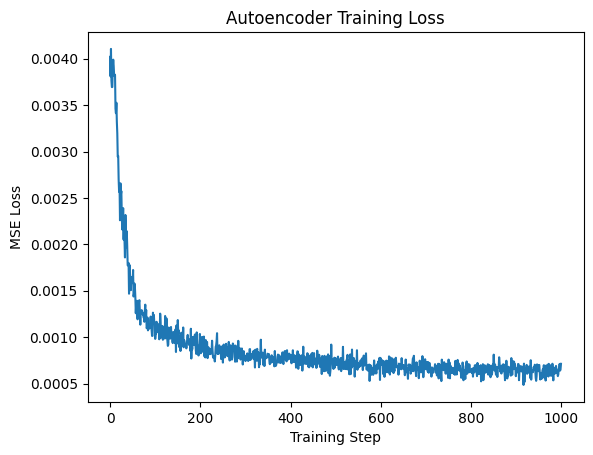

In [37]:
import optax
from flax.training import train_state
import tqdm

# 1. Create optimizer
learning_rate = 2e-3
optimizer = optax.adam(learning_rate)

# 2. Create TrainState
# Using TrainState is a best practice in Flax to keep track of model params, optimizer state etc.
class AutoEncoderTrainState(train_state.TrainState):
    # we can add any other things we want to track during training here
    pass

train_state = AutoEncoderTrainState.create(
    apply_fn=autoencoder.apply,
    params=autoencoder_params,
    tx=optimizer,
)

# 3. Define the training step
@jax.jit
def train_step(state, rng):
    """A single training step."""
    rng, reset_rng = jax.random.split(rng)
    
    # Generate new data for each step
    env_state = jit_reset(jax.random.split(reset_rng, NUM_ENVS))
    images = env_state.obs['pixels/depth']
    
    vision_obs = {
        'pixels/depth': images,
    }

    def loss_fn(params):
        reconstructed_images = state.apply_fn(params, vision_obs)
        loss = mse_loss(reconstructed_images, images)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    
    state = state.apply_gradients(grads=grads)
    
    return state, loss, rng

# 4. Training loop
num_training_steps = 1000
training_rng = jax.random.PRNGKey(1)

losses = []

for i in tqdm.tqdm(range(num_training_steps)):
    train_state, loss, training_rng = train_step(train_state, jax.random.PRNGKey(i))
    losses.append(loss)
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.show()


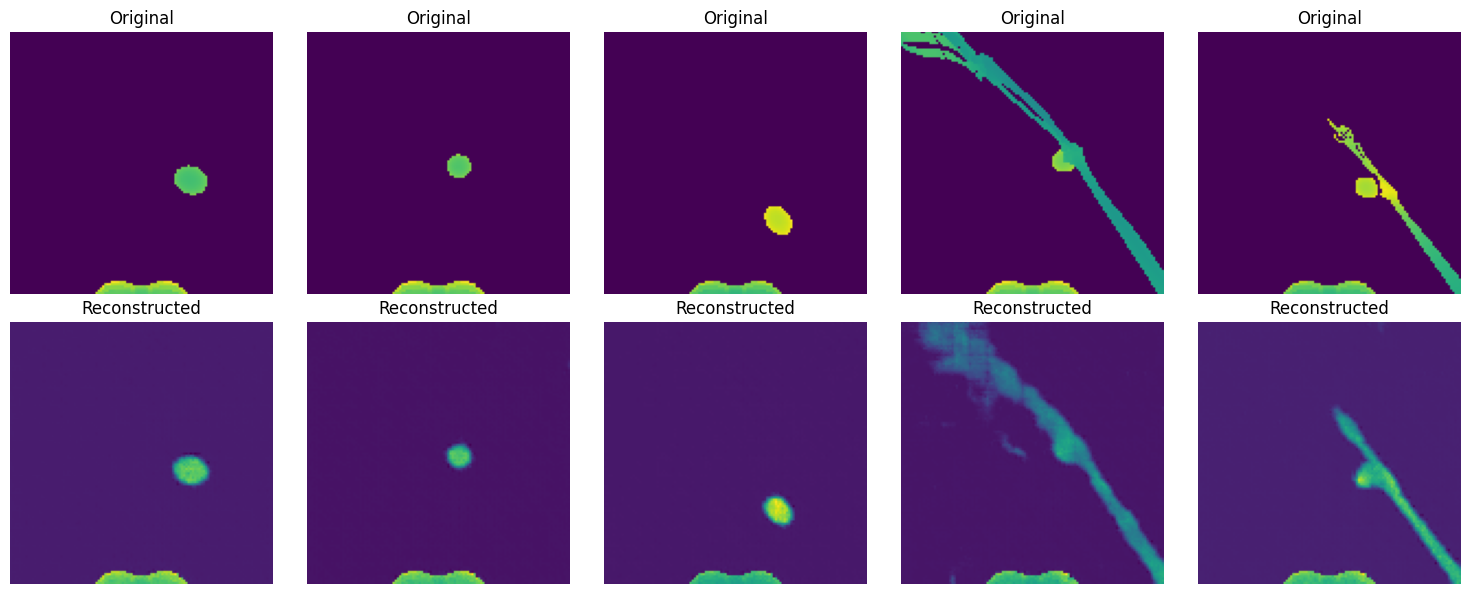

Final loss: 0.0007131780730560422
Training completed! The autoencoder has been trained for 1000 steps.


In [38]:
# 5. Visualize results
# Get a new batch of images
final_rng, reset_rng = jax.random.split(training_rng)
env_state = jit_reset(jax.random.split(reset_rng, NUM_ENVS))
original_images = env_state.obs['pixels/depth']
vision_obs = {'pixels/depth': original_images}

# Get reconstructions
reconstructed_images = train_state.apply_fn(train_state.params, vision_obs)

# Plot a few
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original
    ax[0, i].imshow(original_images[i])
    ax[0, i].set_title("Original")
    ax[0, i].axis('off')
    
    # Reconstructed
    ax[1, i].imshow(reconstructed_images[i])
    ax[1, i].set_title("Reconstructed")
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()

print(f"Final loss: {losses[-1]}")
print(f"Training completed! The autoencoder has been trained for {num_training_steps} steps.")
